In [1]:
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

# import ktrain
import ktrain
from ktrain import text

from pandarallel import pandarallel
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
num_processors = multiprocessing.cpu_count()

In [78]:
pandarallel.initialize(progress_bar=True, nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [36]:
df_segment = pd.read_excel('../NLP/translated_Modifiedv2.xlsx')

In [37]:
df_segment = df_segment[df_segment['only1isused']==1]

In [38]:
df_sentence = pd.read_csv('../NLP/df_sentence.csv')

In [39]:
df_sentence = df_sentence[['sentence_list']]

In [40]:
df_training = pd.read_excel('training_dataset.xlsx')

In [41]:
df_training = df_training[['text', 'ADAS Checked', 'ADAS', 'Affordability Checked',
       'Affordability', 'ComfortQuietness Check', 'ComfortQuietness',
       'ExteriorDesign Check', 'ExteriorDesign', 'FuelEfficiency Check',
       'FuelEfficiency', 'Infortainment Check', 'Infortainment',
       'InteriorDesign Check', 'InteriorDesign', 'Safety Check', 'Safety', 'Utility Check', 'Utility',
       'DP_Ridecomfort', 'DP_Ridecomfort Check']]

In [42]:
df_training.columns = ['sentence_list', 'ADAS_Checked', 'ADAS', 'Affordability_Checked',
       'Affordability', 'ComfortQuietness_Checked', 'ComfortQuietness',
       'ExteriorDesign_Checked', 'ExteriorDesign', 'FuelEfficiency_Checked',
       'FuelEfficiency', 'Infortainment_Checked', 'Infortainment',
       'InteriorDesign_Checked', 'InteriorDesign',
        'Safety_Checked', 'Safety', 'Utility_Checked', 'Utility','DP_Ridecomfort', 'DP_Ridecomfort_Checked']

In [43]:
for cols in df_training.filter(like='_Checked').columns:
    df_training[cols]=df_training[cols].fillna(0)

In [44]:
df_training['Checked'] = df_training['ADAS_Checked'].astype(int) + df_training['Affordability_Checked'].astype(int)  + df_training['ComfortQuietness_Checked'].astype(int) \
+ df_training['ExteriorDesign_Checked'].astype(int)  + df_training['FuelEfficiency_Checked'].astype(int) +\
                df_training['Infortainment_Checked'].astype(int)  + df_training['InteriorDesign_Checked'].astype(int) + df_training['Safety_Checked'].astype(int) + df_training['Utility_Checked'].astype(int) + df_training['DP_Ridecomfort_Checked'].astype(int) 

In [45]:
df_training_combi = df_training[df_training['Checked']>0]

In [46]:
category_lst = ['ADAS', 'Affordability', 'ComfortQuietness','ExteriorDesign', 
       'FuelEfficiency', 'Infortainment','InteriorDesign', 'Safety', 'Utility',
       'DP_Ridecomfort']

In [47]:
df_sentence = pd.merge(df_sentence, df_training_combi[['sentence_list', 'ADAS',
       'Affordability', 'ComfortQuietness','ExteriorDesign', 
       'FuelEfficiency', 'Infortainment','InteriorDesign', 'Safety', 'Utility',
       'DP_Ridecomfort']], on='sentence_list', how='left')

In [135]:
df_segment

,Unnamed: 0,brand,sentence,jpn,L1_Category,L2_Category,L3_Category,Sentiment,only1isused
0,7,Nissan Ariya,"thanks to autonomous driving technology,",自動運転技術のおかげで、,Product,ADAS,Autonomous Drive,positive,1.0
1,67,Nissan Ariya,Developed for the era of electric and autonomo...,電気自動車と自動運転車の時代に向けて開発された、,Product,ADAS,Autonomous Drive,positive,1.0
2,160,Nissan Ariya,"lane holding on the freeway,",高速道路の車線保持、,Product,ADAS,Highway driving assist,neutral,1.0
3,171,Nissan Ariya,advanced driver-assist technologies,高度な運転支援技術,Product,ADAS,Driving Assist,neutral,1.0
4,201,Nissan Ariya,advanced autonomous tech,高度な自律技術,Product,ADAS,Autonomous Drive,positive,1.0
...,...,...,...,...,...,...,...,...,...
23961,30688,Subaru Forester,it follows at a distance,それは遠くに続く,Others,Others,Others,neutral,1.0
23962,33325,Nissan Pathfinder,"it might not detect you,",あなたを検出しないかもしれませんが、,Others,Others,Others,negative,1.0
23963,34726,Toyota Rav4,it is practically useless with polarized sungl...,偏光サングラスではほとんど役に立たない,Others,Others,Others,negative,1.0
23964,37387,Ford F-150,Forward-reverse-forward-reverse,フォワードリバースフォワードリバース,Others,Others,Others,positive,1.0


In [51]:
def check_strings(row, target_strings):
    for string in target_strings:
        if string in row:
            return 1
    return 0

In [49]:
df_segment['L2_Category'] = df_segment['L2_Category'].str.replace('DynamicPerformance', 'DP_Ridecomfort').str.replace('RideComfort', 'DP_Ridecomfort')

In [52]:
for category in category_lst:
    sentence_lst = df_segment[df_segment['L2_Category']==category]['sentence'].tolist()
    df_sentence[category + '_temp'] = df_sentence['sentence_list'].astype(str).apply(lambda x: check_strings(x, sentence_lst))
    df_sentence[category] = df_sentence.apply(lambda x: 1 if (x[category]==1)|(x[category + '_temp']==1) else x[category], axis=1)

In [53]:
df_sentence = df_sentence.drop(df_sentence.filter(like='temp').columns, axis=1)

In [54]:
df_sentence = df_sentence.set_index('sentence_list').dropna(how='all').reset_index().drop_duplicates(subset='sentence_list')

In [55]:
df_sentence.set_index('sentence_list', inplace=True)

In [56]:
category_list = ['ADAS', 'Affordability', 'ComfortQuietness', 
       'FuelEfficiency',  'Infortainment',  'Safety',  'Utility', 'DP_Ridecomfort']

In [57]:
df_dct = {}
for category in category_list:
    df_dct[category] = df_sentence[df_sentence[category]==1].reset_index()
    positive_num = len(df_sentence[df_sentence[category]==1])
    negative_num = len(df_sentence[df_sentence[category]==0])
    try: 
        df_dct[category] = pd.concat([df_dct[category], df_sentence[df_sentence[category]==0]\
                                    .sample(abs(positive_num)).reset_index()], axis=0)[['sentence_list',category]].reset_index(drop=True)
    except:
        df_dct[category] = pd.concat([df_dct[category], df_sentence[df_sentence[category]==0].reset_index()\
                                    ], axis=0)[['sentence_list',category]].reset_index(drop=True)
    df_dct[category].columns = ['text', 'label']

In [23]:
design_category = ['ExteriorDesign', 'InteriorDesign']

In [24]:
for category in design_category:
    df_dct[category] = df_sentence[df_sentence[category]==1].reset_index()
    positive_num = len(df_sentence[df_sentence[category]==1])
    negative_num = len(df_sentence[df_sentence[category]==0]) 
    df_dct[category] = pd.concat([df_dct[category], df_sentence[(df_sentence[category]==0)&(df_sentence[[x for x in design_category if x!=category][0]]==1)].reset_index(drop=True)\
                                 ], axis=0)[['sentence_list',category]].reset_index()
    df_dct[category] = pd.concat([df_dct[category], df_sentence[df_sentence[category]==0]\
                                    .sample(abs(positive_num-len( df_sentence[(df_sentence[category]==0)&(df_sentence[[x for x in design_category if x!=category][0]]==1)]))).reset_index()], axis=0)[['sentence_list',category]].reset_index(drop=True)
    df_dct[category].columns = ['text', 'label']

In [285]:
df_dct['ADAS']['label'].value_counts()

1.0    2436
0.0    2436
Name: label, dtype: int64

In [286]:
category = 'ADAS'

<Axes: >

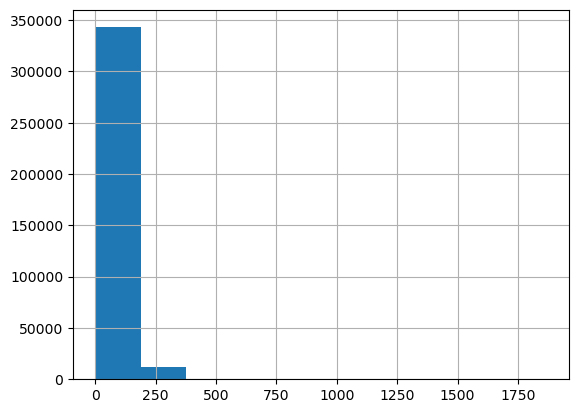

In [157]:
df_sentence['sentence_list'].astype(str).apply(lambda x: len(x)).hist()

In [287]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [288]:
train_data

,text,label
1426,The voice recognition for navigation is 2005 q...,1.0
3077,It's better in every way; nice incremental upg...,0.0
2720,"In the 1st 6 months I had multiple issues, squ...",0.0
3870,"Better gas mileage, and handles very nicely wi...",0.0
4377,I bought the Grand Touring model mainly becaus...,0.0
...,...,...
3084,"As for the minor stuff, the cabin noise is ver...",0.0
4604,The style and color won her over.,0.0
2210,Driver assist and adaptive cruise control are ...,1.0
2435,I still appreciate the front and rear cameras ...,1.0


In [289]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [ ]:
learner.lr_find(max_epochs=3)


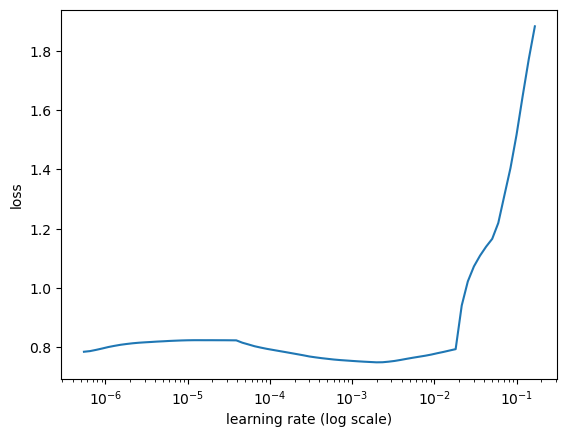

In [24]:
learner.lr_plot()

In [290]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
220/220 [==============================] - 1159s 5s/step - loss: 0.3696 - accuracy: 0.8112 - val_loss: 0.1598 - val_accuracy: 0.9247
Epoch 2/3
220/220 [==============================] - 976s 4s/step - loss: 0.1199 - accuracy: 0.9538 - val_loss: 0.1598 - val_accuracy: 0.9373
Epoch 3/3
28/28 [==============================] - 118s 3s/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       458
           1       0.90      0.95      0.93       419

    accuracy                           0.93       877
   macro avg       0.93      0.93      0.93       877
weighted avg       0.93      0.93      0.93       877



array([[413,  45],
       [ 19, 400]])

In [291]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [317]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 95ms/step


In [318]:
test_data['predict'].unique()

array(['not_label', 'label'], dtype=object)

In [321]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [324]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [325]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       246
           1       0.91      0.96      0.94       242

    accuracy                           0.93       488
   macro avg       0.94      0.93      0.93       488
weighted avg       0.94      0.93      0.93       488



In [326]:
category

'ADAS'

In [327]:
df_edmunds = pd.read_csv('../NLP/df_sentence.csv')

In [333]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 30241s 2s/step


In [334]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv')

# Affordabiilty

In [335]:
category = 'Affordability'

In [336]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [337]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [338]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
222/222 [==============================] - 1299s 6s/step - loss: 0.2853 - accuracy: 0.8780 - val_loss: 0.1877 - val_accuracy: 0.9132
Epoch 2/3
222/222 [==============================] - 1005s 5s/step - loss: 0.1191 - accuracy: 0.9555 - val_loss: 0.1899 - val_accuracy: 0.9211
Epoch 3/3
28/28 [==============================] - 133s 3s/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       450
           1       0.90      0.94      0.92       437

    accuracy                           0.92       887
   macro avg       0.92      0.92      0.92       887
weighted avg       0.92      0.92      0.92       887



array([[405,  45],
       [ 26, 411]])

In [339]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [340]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 113ms/step


In [341]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [342]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [343]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.96      0.87      0.92       254
           1       0.88      0.96      0.92       239

    accuracy                           0.92       493
   macro avg       0.92      0.92      0.92       493
weighted avg       0.92      0.92      0.92       493



In [344]:
category

'Affordability'

In [345]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 41297s 3s/step


In [346]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv')

In [25]:
df_edmunds = pd.read_csv('df_inference.csv')

# ComfortQuietness

In [32]:
category = 'ComfortQuietness'

In [38]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [39]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/ktrain/utils.py:768: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn(
/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/ktrain/utils.py:768: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn(


['not_label', 'label']
      not_label  label
8083        1.0    0.0
6643        1.0    0.0
7304        1.0    0.0
3581        0.0    1.0
3678        0.0    1.0
['not_label', 'label']
      not_label  label
4735        1.0    0.0
1490        0.0    1.0
4884        1.0    0.0
7470        1.0    0.0
1789        0.0    1.0


Is Multi-Label? False
maxlen is 200
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [40]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
404/404 [==============================] - 1776s 4s/step - loss: 0.2836 - accuracy: 0.8761 - val_loss: 0.1290 - val_accuracy: 0.9523
Epoch 2/3
404/404 [==============================] - 2008s 5s/step - loss: 0.1120 - accuracy: 0.9591 - val_loss: 0.0972 - val_accuracy: 0.9647
Epoch 3/3
51/51 [==============================] - 143s 3s/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       805
           1       0.96      0.97      0.97       810

    accuracy                           0.96      1615
   macro avg       0.96      0.96      0.96      1615
weighted avg       0.96      0.96      0.96      1615



array([[772,  33],
       [ 24, 786]])

In [41]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [42]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 119ms/step


In [43]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [44]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [45]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       443
           1       0.95      0.96      0.95       454

    accuracy                           0.95       897
   macro avg       0.95      0.95      0.95       897
weighted avg       0.95      0.95      0.95       897



In [46]:
category

'ComfortQuietness'

In [47]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 32088s 2s/step


In [48]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'_1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)

# FuelEfficiency

In [49]:
category = 'FuelEfficiency'

In [50]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [51]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [52]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
206/206 [==============================] - 1000s 5s/step - loss: 0.2277 - accuracy: 0.9077 - val_loss: 0.0789 - val_accuracy: 0.9757
Epoch 2/3
206/206 [==============================] - 910s 4s/step - loss: 0.0727 - accuracy: 0.9757 - val_loss: 0.0815 - val_accuracy: 0.9721
Epoch 3/3
26/26 [==============================] - 98s 3s/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       417
           1       0.98      0.96      0.97       407

    accuracy                           0.97       824
   macro avg       0.97      0.97      0.97       824
weighted avg       0.97      0.97      0.97       824



array([[408,   9],
       [ 15, 392]])

In [53]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [54]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 127ms/step


In [55]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [56]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [57]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       217
           1       1.00      0.97      0.98       241

    accuracy                           0.98       458
   macro avg       0.98      0.98      0.98       458
weighted avg       0.98      0.98      0.98       458



In [58]:
category

'FuelEfficiency'

In [59]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 42718s 3s/step


In [60]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'_1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)

# Infortainment

In [ ]:
category_lst = ['ADAS', 'Affordability', 'ComfortQuietness','ExteriorDesign', 
       'FuelEfficiency', 'Infortainment','InteriorDesign', 'Safety', 'Utility',
       'DP_Ridecomfort']

In [61]:
category = 'Infortainment'

In [62]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [63]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [64]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
78/78 [==============================] - 597s 7s/step - loss: 0.4823 - accuracy: 0.7556 - val_loss: 0.2686 - val_accuracy: 0.8939
Epoch 2/3
78/78 [==============================] - 430s 6s/step - loss: 0.1776 - accuracy: 0.9306 - val_loss: 0.2070 - val_accuracy: 0.9196
Epoch 3/3
10/10 [==============================] - 49s 4s/step
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       152
           1       0.94      0.91      0.92       159

    accuracy                           0.92       311
   macro avg       0.92      0.92      0.92       311
weighted avg       0.92      0.92      0.92       311



array([[142,  10],
       [ 15, 144]])

In [65]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [66]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 85ms/step


In [67]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [68]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [69]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95        83
           1       0.96      0.94      0.95        90

    accuracy                           0.95       173
   macro avg       0.95      0.95      0.95       173
weighted avg       0.95      0.95      0.95       173



In [70]:
category

'Infortainment'

In [71]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 33298s 2s/step


In [72]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'_1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)

# ExteriorDesign

In [ ]:
category_lst = ['ADAS', 'Affordability', 'ComfortQuietness','ExteriorDesign', 
       'FuelEfficiency', 'Infortainment','InteriorDesign', 'Safety', 'Utility',
       'DP_Ridecomfort']

In [73]:
category = 'ExteriorDesign'

In [74]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [75]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [76]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
251/251 [==============================] - 1250s 5s/step - loss: 0.3461 - accuracy: 0.8398 - val_loss: 0.2204 - val_accuracy: 0.9232
Epoch 2/3
251/251 [==============================] - 1192s 5s/step - loss: 0.1614 - accuracy: 0.9379 - val_loss: 0.2196 - val_accuracy: 0.9112
Epoch 3/3
32/32 [==============================] - 161s 4s/step
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       488
           1       0.90      0.95      0.92       514

    accuracy                           0.92      1002
   macro avg       0.92      0.92      0.92      1002
weighted avg       0.92      0.92      0.92      1002



array([[431,  57],
       [ 26, 488]])

In [77]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [78]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 146ms/step


In [79]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [80]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [81]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       281
           1       0.90      0.91      0.90       276

    accuracy                           0.90       557
   macro avg       0.90      0.90      0.90       557
weighted avg       0.90      0.90      0.90       557



In [82]:
category

'ExteriorDesign'

In [83]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 45628s 3s/step


In [84]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'_1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)

# InteriorDesign

In [85]:
category_lst = ['ADAS', 'Affordability', 'ComfortQuietness','ExteriorDesign', 
       'FuelEfficiency', 'Infortainment','InteriorDesign', 'Safety', 'Utility',
       'DP_Ridecomfort']

In [86]:
category = 'InteriorDesign'

In [87]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [88]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [89]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
145/145 [==============================] - 1227s 8s/step - loss: 0.3516 - accuracy: 0.8341 - val_loss: 0.1995 - val_accuracy: 0.9206
Epoch 2/3
145/145 [==============================] - 858s 6s/step - loss: 0.1559 - accuracy: 0.9404 - val_loss: 0.1955 - val_accuracy: 0.9188
Epoch 3/3
19/19 [==============================] - 128s 6s/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       301
           1       0.93      0.93      0.93       278

    accuracy                           0.93       579
   macro avg       0.93      0.93      0.93       579
weighted avg       0.93      0.93      0.93       579



array([[280,  21],
       [ 19, 259]])

In [90]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [91]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 105ms/step


In [92]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [93]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [94]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       174
           1       0.90      0.95      0.92       148

    accuracy                           0.93       322
   macro avg       0.93      0.93      0.93       322
weighted avg       0.93      0.93      0.93       322



In [95]:
category

'InteriorDesign'

In [96]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 32378s 2s/step


In [97]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'_1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)

# Safety

In [ ]:
category_lst = ['ADAS', 'Affordability', 'ComfortQuietness','ExteriorDesign', 
       'FuelEfficiency', 'Infortainment','InteriorDesign', 'Safety', 'Utility',
       'DP_Ridecomfort']

In [98]:
category = 'Safety'

In [99]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [100]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [101]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
275/275 [==============================] - 1315s 4s/step - loss: 0.2553 - accuracy: 0.8766 - val_loss: 0.1466 - val_accuracy: 0.9491
Epoch 2/3
275/275 [==============================] - 1212s 4s/step - loss: 0.0869 - accuracy: 0.9666 - val_loss: 0.1416 - val_accuracy: 0.9427
Epoch 3/3
35/35 [==============================] - 153s 4s/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       558
           1       0.96      0.95      0.96       542

    accuracy                           0.96      1100
   macro avg       0.96      0.96      0.96      1100
weighted avg       0.96      0.96      0.96      1100



array([[538,  20],
       [ 25, 517]])

In [102]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [103]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 100ms/step


In [104]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [105]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [106]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       320
           1       0.97      0.95      0.96       292

    accuracy                           0.96       612
   macro avg       0.96      0.96      0.96       612
weighted avg       0.96      0.96      0.96       612



In [107]:
category

'Safety'

In [108]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 41009s 3s/step


In [109]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'_1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)

# Utility

In [ ]:
category_lst = ['ADAS', 'Affordability', 'ComfortQuietness','ExteriorDesign', 
       'FuelEfficiency', 'Infortainment','InteriorDesign', 'Safety', 'Utility',
       'DP_Ridecomfort']

In [110]:
category = 'Utility'

In [111]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [112]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [113]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
203/203 [==============================] - 1826s 8s/step - loss: 0.4655 - accuracy: 0.7747 - val_loss: 0.2988 - val_accuracy: 0.8765
Epoch 2/3
203/203 [==============================] - 1394s 7s/step - loss: 0.2444 - accuracy: 0.9033 - val_loss: 0.2935 - val_accuracy: 0.8790
Epoch 3/3
26/26 [==============================] - 162s 5s/step
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       416
           1       0.86      0.92      0.88       394

    accuracy                           0.88       810
   macro avg       0.89      0.88      0.88       810
weighted avg       0.89      0.88      0.88       810



array([[355,  61],
       [ 33, 361]])

In [114]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [115]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 111ms/step


In [116]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [117]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [118]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       222
           1       0.86      0.90      0.88       228

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450



In [119]:
category

'Utility'

In [120]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 32823s 2s/step


In [121]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'_1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)

# DP_Ridecomfort

In [ ]:
category_lst = ['ADAS', 'Affordability', 'ComfortQuietness','ExteriorDesign', 
       'FuelEfficiency', 'Infortainment','InteriorDesign', 'Safety', 'Utility',
       'DP_Ridecomfort']

In [122]:
category = 'DP_Ridecomfort'

In [123]:
train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)

In [124]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_dct[category], test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [125]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
445/445 [==============================] - 2425s 5s/step - loss: 0.2346 - accuracy: 0.8964 - val_loss: 0.1287 - val_accuracy: 0.9556
Epoch 2/3
445/445 [==============================] - 1859s 4s/step - loss: 0.0854 - accuracy: 0.9708 - val_loss: 0.1169 - val_accuracy: 0.9589
Epoch 3/3
56/56 [==============================] - 228s 3s/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       797
           1       0.95      0.97      0.96       981

    accuracy                           0.96      1778
   macro avg       0.96      0.95      0.96      1778
weighted avg       0.96      0.96      0.96      1778



array([[746,  51],
       [ 26, 955]])

In [126]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [127]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 106ms/step


In [128]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [129]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [130]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       447
           1       0.96      0.97      0.96       541

    accuracy                           0.96       988
   macro avg       0.96      0.96      0.96       988
weighted avg       0.96      0.96      0.96       988



In [131]:
category

'DP_Ridecomfort'

In [132]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 30313s 2s/step


In [133]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=[category+'_0_prob', category+'_1_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)

# Sentiment

In [2]:
df_edmunds = pd.read_csv('df_inference.csv')

In [7]:
df_sentiment = df_edmunds[(df_edmunds['Star Rating']==5)|(df_edmunds['Star Rating']==1)][['sentence_list', 'Star Rating']]

In [8]:
from transformers import pipeline

In [9]:
classification = pipeline('sentiment-analysis')

In [10]:
df_sentiment = pd.concat([df_sentiment[df_sentiment['Star Rating']==5].sample(25000), df_sentiment[df_sentiment['Star Rating']==1].sample(25000)], axis=0)

In [11]:
def sent_classification(text):
    try:
        return classification(text)[0]
    except:
        pass

In [12]:
df_sentiment['transformer_senti'] = df_sentiment['sentence_list'].apply(lambda x: sent_classification(x))

In [ ]:
df_sentiment = df_sentiment[~df_sentiment['transformer_senti'].isna()]

In [ ]:
df_sentiment['sentiment'] = df_sentiment['transformer_senti'].apply(lambda x: x['label'])

/var/folders/57/0jgh1fz973nb1t0tp3f4y3b80000gn/T/ipykernel_49930/1220351971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment['sentiment'] = df_sentiment['transformer_senti'].apply(lambda x: x['label'])


In [ ]:
df_sentiment['probability'] = df_sentiment['transformer_senti'].apply(lambda x: x['score'])

/var/folders/57/0jgh1fz973nb1t0tp3f4y3b80000gn/T/ipykernel_49930/2037771264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment['probability'] = df_sentiment['transformer_senti'].apply(lambda x: x['score'])


In [ ]:
df_sentiment = df_sentiment[df_sentiment['probability']>0.99]

In [216]:
df_sentiment = df_sentiment[((df_sentiment['Star Rating'] == 5)&(df_sentiment['sentiment'] == 'POSITIVE'))|((df_sentiment['Star Rating'] == 1)&(df_sentiment['sentiment'] == 'NEGATIVE'))]

In [219]:
df_sentiment.to_csv('trial.csv')

In [3]:
df_sentiment = pd.read_csv('trial.csv')

In [30]:
df_sent_train = pd.concat([df_sentiment[df_sentiment['sentiment']=='POSITIVE'], df_sentiment[df_sentiment['sentiment']=='NEGATIVE'].sample(11815)], axis=0)

In [31]:
df_sent_train = df_sent_train[['sentence_list', 'sentiment']].reset_index(drop=True)

In [32]:
df_sent_train['sentiment'] = df_sent_train['sentiment'].replace('POSITIVE', 1).replace('NEGATIVE', 0)

In [33]:
df_sent_train.columns = ['text', 'label']

In [34]:
df_sent_train

,text,label
0,A car with a Lotta! .,1
1,Great car!!!would purchase again in a heartbeat.,1
2,You can feel it when you are driving in the re...,1
3,Beautiful car inside and out that is really fu...,1
4,"Awesome technology, great ride, and the turbo ...",1
...,...,...
23625,Do not buy a diesel Cruze!,0
23626,Subarus exact words and what is written on my ...,0
23627,I cannot believe I paid over $62K for a vehicl...,0
23628,They have diagnosed the problem as a leaking A...,0


In [59]:
df_sent_train.to_csv('df_sent_train.csv', index=False)

In [60]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
preprocessMode='bert' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.2 #Proportion of training to use for validation

train_data, test_data = train_test_split(df_sent_train, test_size=0.1, train_size=0.9)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = train_data, 
                                                                    text_column  = 'text', 
                                                                    label_columns = ['label'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen)
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16 ### Check best size

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)




Is Multi-Label? False
maxlen is 200


/Users/daisukeyagyu/miniforge3/envs/NLP_env/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [61]:
learningRate = 2e-5
numEpoch = 3

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)
learner.validate(val_data=(x_test, y_test))




begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
1064/1064 [==============================] - 3708s 3s/step - loss: 0.0996 - accuracy: 0.9627 - val_loss: 0.0470 - val_accuracy: 0.9868
Epoch 2/3
1064/1064 [==============================] - 5313s 5s/step - loss: 0.0211 - accuracy: 0.9929 - val_loss: 0.0434 - val_accuracy: 0.9873
Epoch 3/3
133/133 [==============================] - 265s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2093
           1       0.99      0.99      0.99      2161

    accuracy                           0.99      4254
   macro avg       0.99      0.99      0.99      4254
weighted avg       0.99      0.99      0.99      4254



array([[2067,   26],
       [  20, 2141]])

In [62]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [63]:
test_data['predict'] = test_data['text'].apply(lambda x: predictor.predict(x))

1/1 [==============================] - 0s 94ms/step


In [64]:
test_data

,text,label,predict
13446,I’ve regretted it since.,0,not_label
83,Ridgeline smooth gets great fuel economy it kn...,1,label
16507,"Sounds like metal on metal, called gm called t...",0,not_label
17163,I feel something was missed at the factory.,0,not_label
17168,"Blocking traffic, police arrived, tow truck ar...",0,not_label
...,...,...,...
1213,The seats are comfortable enough for a 4+ hour...,1,label
2596,And I like it alot better than the Versa.,1,label
1871,A lot of features and a good ride,1,label
8424,Toyota stands behind what they sell.,1,label


In [65]:
test_data['predict'].unique()

array(['not_label', 'label'], dtype=object)

In [66]:
test_data['predict'] = test_data['predict'].str.replace('not_label','0').str.replace('label','1')

In [67]:
test_data['label'] = test_data['label'].astype(int).astype(str)

In [68]:
print(classification_report(test_data['label'], test_data['predict']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1169
           1       0.99      0.99      0.99      1194

    accuracy                           0.99      2363
   macro avg       0.99      0.99      0.99      2363
weighted avg       0.99      0.99      0.99      2363



In [69]:
predicted = predictor.predict_proba(df_edmunds.sentence_list.iloc[:].tolist())

16131/16131 [==============================] - 30608s 2s/step


In [70]:
df_edmunds = pd.concat([df_edmunds, pd.DataFrame(predicted, columns=['sentiment_nega_prob', 'sentiment_posi_prob'])], axis=1)
df_edmunds.to_csv('df_inference.csv', index=False)